<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/test_large_batch_optimezer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch

## Imports

In [ ]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torchvision
import torchvision.transforms as transforms
import random
import math
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR, LambdaLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Costants

In [ ]:
NUM_EPOCHS = 150
BATCH_SIZE = 64
LR = 0.01       # Choose 'SGDM': "lr": 0.01, "weight_decay": 0.001, "momentum": 0.9,
WD = 0.001      # Choose 'AdamW': "lr": 0.001, "weight_decay": 0.1,
MOMENTUM = 0.9
EPS = 0.0001
OPTIMIZER = 'LARS'  # Choose from: 'SGDM', 'AdamW', 'LARS', 'LAMB'

## Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [ ]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [ ]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")

    return train_dataset, train_loader, val_loader, test_loader

In [ ]:
class CheckpointSaver:

  def __init__(self, path, OPTIMIZER, batch_size, hyperparams, epochs):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = f"{path}/{OPTIMIZER}_{batch_size}_{self.timestamp}"
    self.hyperparams = hyperparams
    self.epochs = epochs

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'train_acc': os.path.join(self.path, f'{OPTIMIZER}_{batch_size}_train_accuracy_{self.timestamp}.txt'),
        'val_acc': os.path.join(self.path, f'{OPTIMIZER}_{batch_size}_val_accuracy_{self.timestamp}.txt'),
        'train_loss': os.path.join(self.path, f'{OPTIMIZER}_{batch_size}_train_loss_{self.timestamp}.txt'),
        'val_loss': os.path.join(self.path, f'{OPTIMIZER}_{batch_size}_val_loss_{self.timestamp}.txt')
    }

    with open(os.path.join(self.path, f'{OPTIMIZER}_{batch_size}_experiment_config_{self.timestamp}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: {OPTIMIZER}\n")
        f.write(f"Batch Size: {batch_size}\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")


  def save_checkpoint(self, epoch, train_acc, val_acc, train_loss, val_loss):
      try:
          with open(self.metrics_files['train_acc'], 'a') as f:
              f.write(f"{epoch+1},{train_acc * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch+1},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['train_loss'], 'a') as f:
              f.write(f"{epoch+1},{train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch+1},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")


## Defining different optimizers

In [ ]:
class LARS(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, batch_size=32, weight_decay=1e-4, epsilon=1e-8):
        defaults = dict(lr=lr, beta1=beta1, batch_size=batch_size,
                       weight_decay=weight_decay, epsilon=epsilon)
        super(LARS, self).__init__(params, defaults)

        # Initialize momentum
        self.m0 = {param: torch.zeros_like(param.data) for group in self.param_groups
                   for param in group['params']}

    def phi(self, norm):
        """Scaling function φ as defined in the paper"""
        return torch.ones_like(norm)  # Can be modified for different scaling strategies

    def get_batch_samples(self, dataset, batch_size):
        """Draw b samples from the dataset"""
        indices = torch.randperm(len(dataset))[:batch_size]
        return [dataset[i] for i in indices]

    @torch.no_grad()
    def step(self, closure=None, dataset=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1 = group['beta1']
            lr = group['lr']
            weight_decay = group['weight_decay']
            epsilon = group['epsilon']

            # Draw batch samples if dataset provided
            if dataset is not None:
                batch = self.get_batch_samples(dataset, group['batch_size'])

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad
                state = self.state[param]

                # Compute gt (gradient plus weight decay)
                gt = grad + weight_decay * param.data

                # Update momentum mt
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)
                mt = state['momentum']
                mt.mul_(beta1).add_((1 - beta1) * (gt + weight_decay * param.data))

                # Compute the update with φ scaling
                param_norm = param.data.norm(2).clamp(min=epsilon)
                mt_norm = mt.norm(2).clamp(min=epsilon)

                update = lr * (self.phi(param_norm) / mt_norm) * mt

                # Update parameters
                param.data.sub_(update)

        return loss


class LAMB(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # m_t = β₁m_{t-1} + (1-β₁)g_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # v_t = β₂v_{t-1} + (1-β₂)g_t²
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # m̂_t = m_t/(1-β₁ᵗ)
                exp_avg_hat = exp_avg / bias_correction1
                # v̂_t = v_t/(1-β₂ᵗ)
                exp_avg_sq_hat = exp_avg_sq / bias_correction2

                # r_t = m̂_t/√(v̂_t + ε)
                denom = exp_avg_sq_hat.sqrt().add_(group['eps'])
                update = exp_avg_hat / denom

                # r_t + λx_t
                if group['weight_decay'] > 0:
                    update.add_(p.data, alpha=group['weight_decay'])

                # Compute trust ratio φ(‖x_t‖)/‖r_t + λx_t‖
                w_norm = p.data.norm(p=2)
                g_norm = update.norm(p=2)
                trust_ratio = torch.where(
                    w_norm > 0,
                    w_norm / (g_norm + group['eps']),
                    torch.ones_like(w_norm)
                )

                # x_{t+1} = x_t - η·trust_ratio·(r_t + λx_t)
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss

## Training function

In [ ]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, hyperparams, num_epochs, device, type_of_optimizer, batch_size, train_dataset):
    model = LeNet5().to(device)

    if type_of_optimizer == "SGDM":
        if hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        optimizer = optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            momentum=hyperparams['momentum'],
            weight_decay=hyperparams['weight_decay']
        )

    elif type_of_optimizer == "AdamW":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        optimizer = optim.AdamW(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )

    elif type_of_optimizer == "LAMB":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LAMB")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LAMB")

        optimizer = LAMB(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )

    elif type_of_optimizer == "LARS":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LARS")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LARS")

        optimizer = LARS(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )
    else:
        raise ValueError("Invalid optimizer type")

    print(f"Train running with {type_of_optimizer} optimizer.")


    iterations_per_epoch = len(train_dataset) // batch_size
    warmup_epoch = 5
    def warmup_scheduler_fn(epoch):
        if epoch < warmup_epoch:
            return float(epoch+1) / warmup_epoch
        return 1.0

    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_scheduler_fn)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epoch)
    criterion = nn.CrossEntropyLoss()

    cs = CheckpointSaver(
        path=f"/content/drive/My Drive/Colab Notebooks/Traning_summary/",
        OPTIMIZER=OPTIMIZER,
        batch_size=batch_size,
        hyperparams=hyperparams,
        epochs=num_epochs
    )

    cs.create_files()


    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        cs.save_checkpoint(epoch, train_acc, val_acc, train_loss, val_loss)


        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


        if epoch < warmup_epoch:
            warmup_scheduler.step()
        else:
            scheduler.step()



    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, cs.path

In [ ]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")
    print(f"Training results saved to {save_path} as 'training_results.png'")
    plt.show()

## Main

Start loading data with batch_size 128


100%|██████████| 169M/169M [00:18<00:00, 9.00MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 2.02 seconds
Batch 0: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 1: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 2: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 3: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 4: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 5: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 6: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 7: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 8: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size(

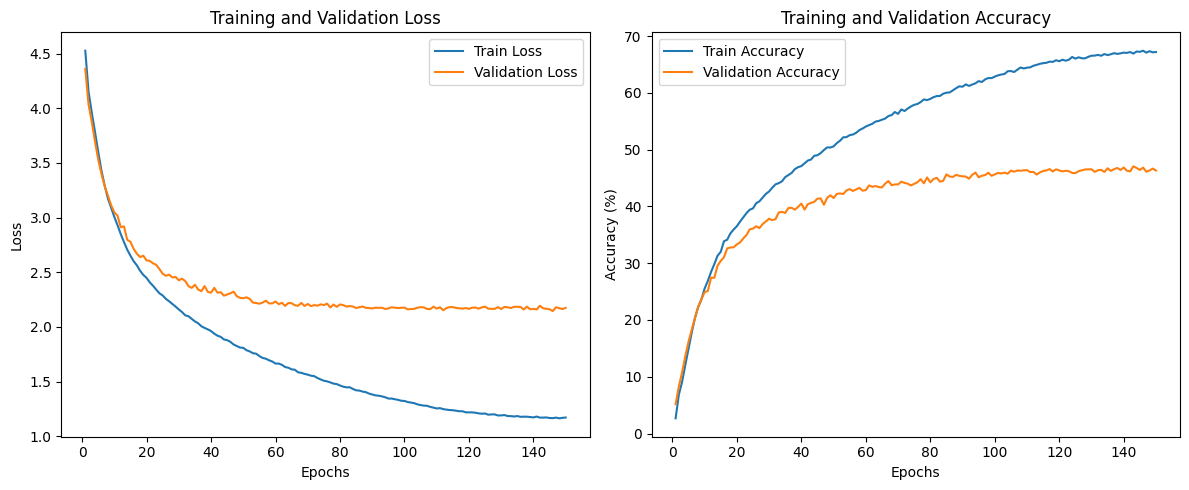

Start loading data with batch_size 256
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.74 seconds
Batch 0: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 1: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 2: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 3: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 4: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 5: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 6: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 7: inputs shape: torch.Size([256, 3, 32, 32]), labels shape: torch.Size([256])
Batch 8: inputs shape: torch.Size([256, 3, 32, 32]), 

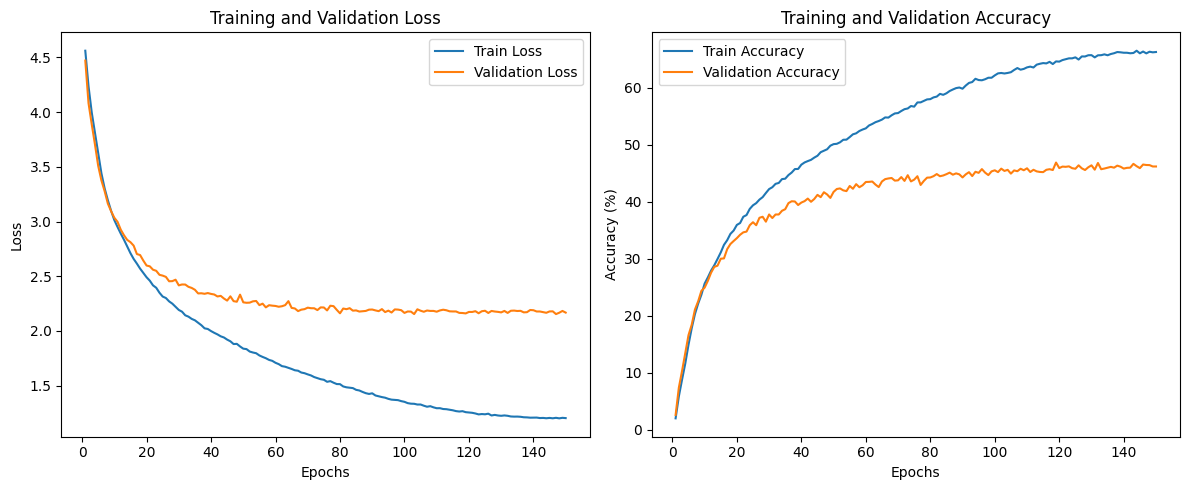

Start loading data with batch_size 512
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.96 seconds
Batch 0: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 1: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 2: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 3: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 4: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 5: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 6: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 7: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 8: inputs shape: torch.Size([512, 3, 32, 32]), 

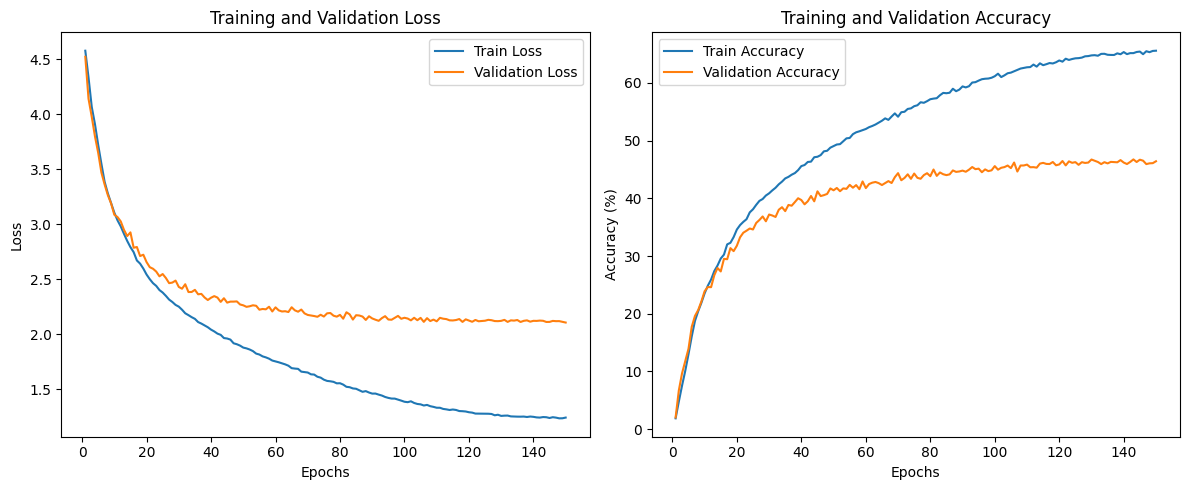

Start loading data with batch_size 1024
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.88 seconds
Batch 0: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 1: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 2: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 3: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 4: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 5: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 6: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 7: inputs shape: torch.Size([1024, 3, 32, 32]), labels shape: torch.Size([1024])
Batch 8: inputs shape: torch.Size([1

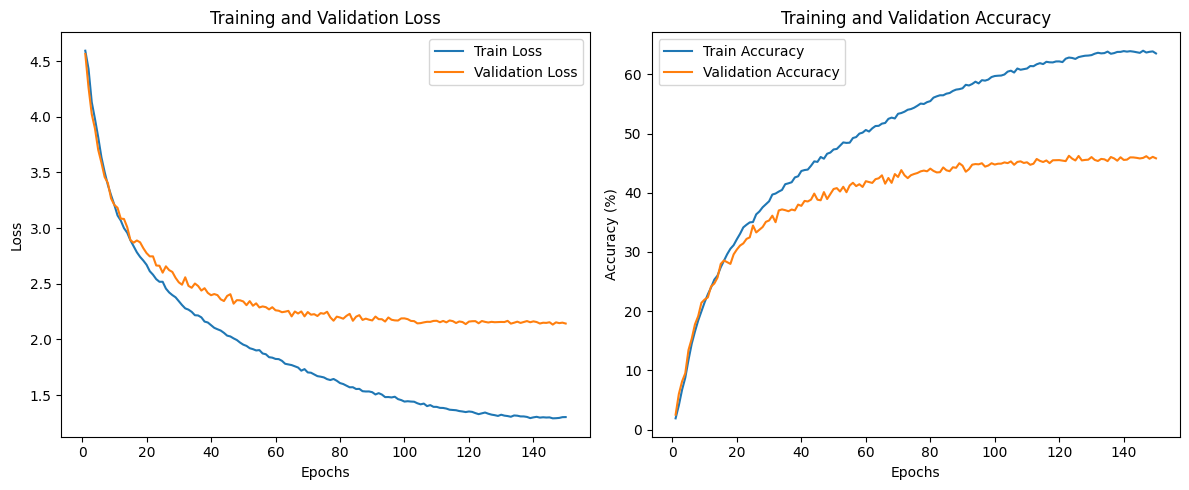

Start loading data with batch_size 2048
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.73 seconds
Batch 0: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 1: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 2: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 3: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 4: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 5: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 6: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 7: inputs shape: torch.Size([2048, 3, 32, 32]), labels shape: torch.Size([2048])
Batch 8: inputs shape: torch.Size([2

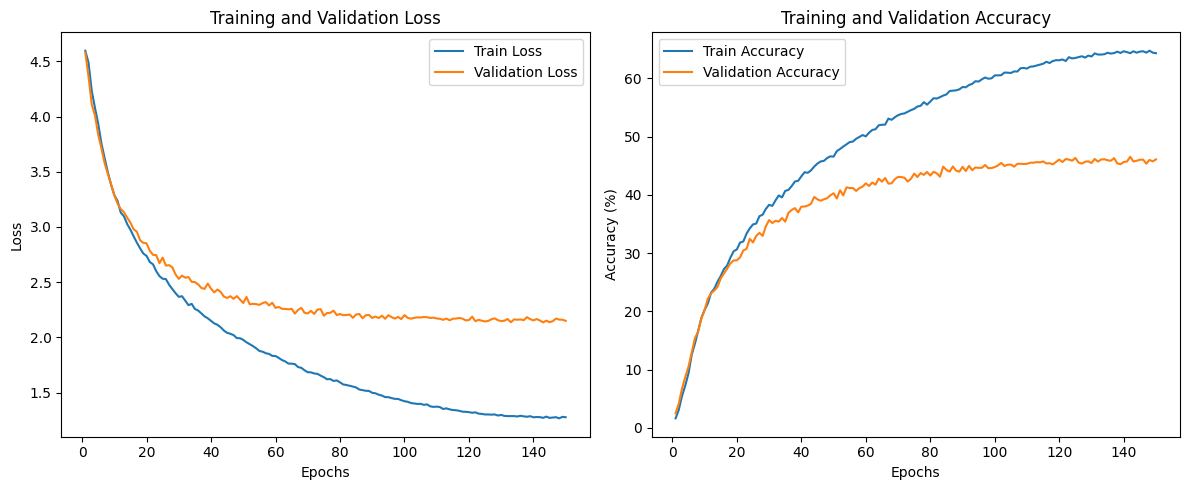

Start loading data with batch_size 4096
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.77 seconds
Batch 0: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 1: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 2: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 3: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 4: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 5: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 6: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 7: inputs shape: torch.Size([4096, 3, 32, 32]), labels shape: torch.Size([4096])
Batch 8: inputs shape: torch.Size([4

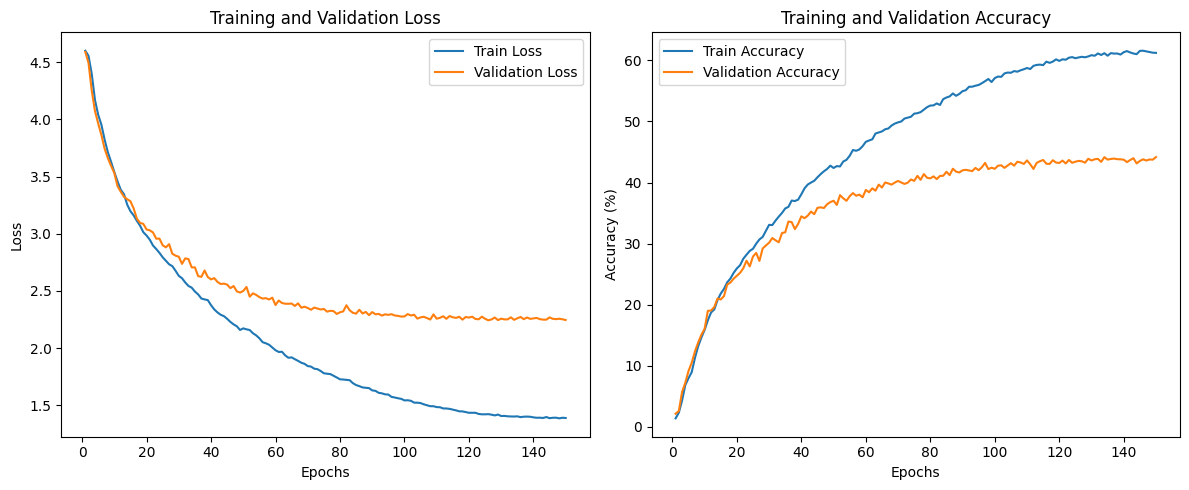

Start loading data with batch_size 8192
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.74 seconds
Batch 0: inputs shape: torch.Size([8192, 3, 32, 32]), labels shape: torch.Size([8192])
Batch 1: inputs shape: torch.Size([8192, 3, 32, 32]), labels shape: torch.Size([8192])
Batch 2: inputs shape: torch.Size([8192, 3, 32, 32]), labels shape: torch.Size([8192])
Batch 3: inputs shape: torch.Size([8192, 3, 32, 32]), labels shape: torch.Size([8192])
Batch 4: inputs shape: torch.Size([7232, 3, 32, 32]), labels shape: torch.Size([7232])
Data loading for 10 batches completed.
Using hyperparams: lr: 0.11313708498984762, weight_decay: 0.001
Train running with LARS optimizer.
Epoch 1/150 | Train Loss: 4.6039, Train Acc: 0.88% | Val Loss: 4.5998, Val Acc: 1.28%
Epoch 2/150 | Train Loss: 4.5887, Train Acc: 2.13% | Val Loss: 4.5672, Va

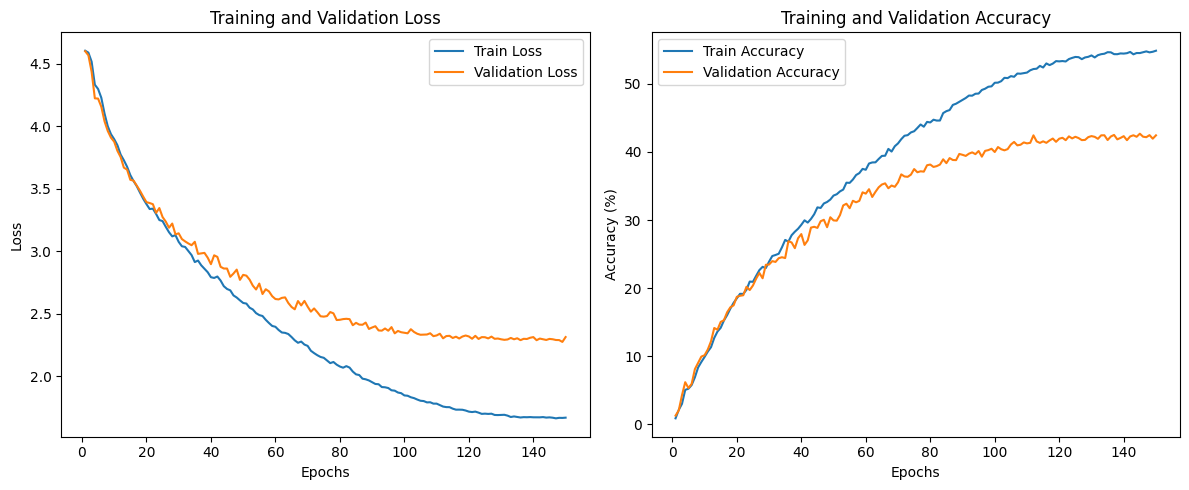

In [ ]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    all_train_losses = {}
    all_val_losses = {}
    all_train_accuracies = {}
    all_val_accuracies = {}
    all_test_accuracies = {}

    batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

    for batch_size in batch_sizes:

        train_dataset, train_loader, val_loader, test_loader = get_dataset(batch_size)

        base_lr = LR
        base_batch_size = BATCH_SIZE
        lr = base_lr * math.sqrt(batch_size/base_batch_size)
        hyperparams = {
            'lr': lr,
            'weight_decay': WD,
        }

        print(f"Using hyperparams: lr: {hyperparams['lr']}, weight_decay: {hyperparams['weight_decay']}")

        # Train with the best hyperparameters
        train_losses, val_losses, train_accuracies, val_accuracies, test_acc, save_path= train_model_with_hyperparams(
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            hyperparams=hyperparams,
            num_epochs=NUM_EPOCHS,
            device=device,
            type_of_optimizer=OPTIMIZER,
            batch_size=batch_size,
            train_dataset=train_dataset
        )

        plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path)